In [20]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [29]:
# Multi-input classifier - boundary outlier samples

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 2
        self.input_dim = 2
        self.epochs = 300
        self.batch_size = 32
        self.data, self.labels, self.data_out, self.labels_out = self.get_data()
        # Oultiers from rectagle outside 2 circles
        self.data_outlier, self.labels_outlier = self.get_outlier_data()

        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.X_train_outliers, self.X_test_outliers, self.y_train_outliers, self.y_test_outliers = train_test_split(self.data_out, self.labels_out, test_size=0.5, shuffle=True,
                                                            random_state=1)
        self.multi_input_classifier, self.model = self.get_model()


        self.mu = np.mean(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)
        self.sigma = np.std(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)

        self.data = self.preprocess_data(self.data)
        self.data_out = self.preprocess_data(self.data_out)
        self.data_outlier = self.preprocess_data(self.data_outlier)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)
        self.X_train_outlier = self.preprocess_data(self.X_train_outliers)
        self.X_test_outliers = self.preprocess_data(self.X_test_outliers)


    def preprocess_data(self, x):
        # return (x-self.mu)/self.sigma
        return x

    def get_circle_data(self, x, y, r, n):
        rho = np.sqrt(np.random.uniform(0, r, n))
        phi = np.random.uniform(0, 2*np.pi, n)

        data = np.zeros((n, 2))
        data[:, 0] = rho * np.cos(phi) + x
        data[:, 1] = rho * np.sin(phi) + y
        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)
    
    # return True if point (x1, y1) lies inside a circle defined by (x, y, r+0.1)
    def is_in_circle(self, x, y, r, x1, y1):
        return (x-x1)**2 + (y-y1)**2 <= (r+0.1)**2


    
    # generate n outlier points uniformly sampled within rectagle (x1, y1), (h, w) excuding the inlier circles
    def get_outlier_data_sub(self, x1, y1, h, w, cx1, cy1, r1, cx2, cy2, r2, n):
        count = 0
        data = np.zeros((n, 2))
        while count < n:
            x = np.random.uniform(x1, x1+w, 1)
            y = np.random.uniform(y1, y1+h, 1)
            if (not self.is_in_circle(cx1, cy1, r1, x, y)) and (not self.is_in_circle(cx2, cy2, r2, x, y)):
                data[count,0] = x
                data[count,1] = y
                count += 1
        return data

    def get_outlier_data(self):
        data = self.get_outlier_data_sub(-50, -50, 100, 100, -2, 0, 1+0.3, +2, 0, 1+0.3, 1000)
        #data = self.get_outlier_data_sub(-50, -50, 100, 100, -2, 0, 1+0.3, +2, 0, 1+0.3, 1000)
        labels = np.ones((1000,1))*2
        return data.astype(np.float32), labels.astype(np.float32)

    
    # gets a point sampled from region within concentric cercles centered at (x, y) with radii r1 and r2. 
    def get_random_sample_from_strip(self, x, y, r1, r2):
        r = np.random.uniform(r1, r2)
        x1 = np.random.normal(0, r)
        y1 = np.random.normal(0, r)
        d = math.sqrt(x1**2 + y1**2)/r
        return (x1/d)+x, (y1/d)+y

    
    def get_boundary_outlier_data(self, cx1, cy1, r1, cx2, cy2, r2, n):
        count = 0
        data = np.zeros((n, 2))
        # boundary of first circle
        while count < n/2:
            data[count,0], data[count,1] = self.get_random_sample_from_strip(cx1, cy1, r1+0.1, r1+0.3)
            count += 1
        # boundary of second circle
        while count < n:
            data[count,0], data[count,1] = self.get_random_sample_from_strip(cx2, cy2, r2+0.1, r2+0.3)
            count += 1
        return data
    
    def get_data(self):
        # class 0 data
        data = self.get_circle_data(-2, 0, 1, 1000)
        labels = np.ones((1000, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_circle_data(+2, 0, 1, 1000)), axis=0)
        labels = np.concatenate((labels, np.ones((1000, 1))*1), axis=0)
        print(labels.shape)
        # boundary outlier data
        data_out = self.get_boundary_outlier_data(-2, 0, 1, +2, 0, 1, 2000)
        labels_out = np.ones((2000,1))*2
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32), data_out.astype(np.float32), labels_out.astype(np.float32)


    def base_model(self):
        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model

    def get_model(self):
        # instantiate classifier model
        classifier = self.base_model()
        classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.01))

        # just the classifier
        input_data = Input(shape=(self.input_dim, ))
        y_classifier = classifier(input_data)


        # 2 input classifier
        input_a = Input(shape=(self.input_dim, ))
        processed_a = classifier(input_a)
        input_b = Input(shape=(self.input_dim, ))
        processed_b = classifier(input_b)

        out_a = Lambda(lambda x: x, name = 'out_a')(processed_a)
        out_b = Lambda(lambda x: x, name = 'out_b')(processed_b)

        multi_input_classifier = Model(inputs=[input_a, input_b], outputs=[out_a, out_b])
        multi_input_classifier.compile(loss={'out_a':'categorical_crossentropy', 'out_b':'categorical_crossentropy'}, 
                                       loss_weights={'out_a': 1.0, 'out_b': 1.0}, optimizer=Adam(0.01), 
                                       metrics={'out_a':['acc'], 'out_b':['categorical_crossentropy']})


        mnist_model = Model(input_data, y_classifier)
        mnist_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['acc'])

        return multi_input_classifier, mnist_model


    def train(self):
        # fit the model
        Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        Y_train_outliers = np.ones((self.y_train_outliers.shape[0], self.number_of_classes))
        Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)
        Y_test_outliers = np.ones((self.y_test_outliers.shape[0], self.number_of_classes))

        self.multi_input_classifier.fit([self.X_train, self.X_train_outliers], [Y_train, Y_train_outliers], 
                                        epochs=self.epochs, validation_data=([self.X_test, self.X_test_outliers], [Y_test, Y_test_outliers]), batch_size=self.batch_size)     



In [30]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(2000, 1)
((2000, 2), (2000, 1))
Train on 1000 samples, validate on 1000 samples
Epoch 1/300
1000/1000 [==============================] - 0s 410us/step - loss: 2.0224 - out_a_loss: 0.4289 - out_b_loss: 1.5934 - out_a_acc: 0.8940 - out_b_categorical_crossentropy: 1.5934 - val_loss: 1.7791 - val_out_a_loss: 0.2053 - val_out_b_loss: 1.5738 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5738
Epoch 2/300
1000/1000 [==============================] - 0s 130us/step - loss: 1.7402 - out_a_loss: 0.2353 - out_b_loss: 1.5049 - out_a_acc: 0.9850 - out_b_categorical_crossentropy: 1.5049 - val_loss: 1.6402 - val_out_a_loss: 0.2053 - val_out_b_loss: 1.4349 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4349
Epoch 3/300
1000/1000 [==============================] - 0s 117us/step - loss: 1.5884 - out_a_loss: 0.1331 - out_b_loss: 1.4553 - out_a_acc: 0.9980 - out_b_categorical_crossentropy: 1.4553 - val_loss: 1.5597 - val_out_a_loss: 0.1396 - val_out_b_

Epoch 26/300
1000/1000 [==============================] - 0s 115us/step - loss: 1.4166 - out_a_loss: 0.0205 - out_b_loss: 1.3961 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3961 - val_loss: 1.4056 - val_out_a_loss: 0.0180 - val_out_b_loss: 1.3876 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3876
Epoch 27/300
1000/1000 [==============================] - 0s 112us/step - loss: 1.4225 - out_a_loss: 0.0246 - out_b_loss: 1.3980 - out_a_acc: 0.9950 - out_b_categorical_crossentropy: 1.3980 - val_loss: 1.4027 - val_out_a_loss: 0.0129 - val_out_b_loss: 1.3898 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3898
Epoch 28/300
1000/1000 [==============================] - 0s 111us/step - loss: 1.4378 - out_a_loss: 0.0403 - out_b_loss: 1.3975 - out_a_acc: 0.9870 - out_b_categorical_crossentropy: 1.3975 - val_loss: 1.5504 - val_out_a_loss: 0.1530 - val_out_b_loss: 1.3974 - val_out_a_acc: 0.9010 - val_out_b_categorical_crossentropy: 1.3974
Epoch 29/300
100

Epoch 51/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.4273 - out_a_loss: 0.0301 - out_b_loss: 1.3973 - out_a_acc: 0.9930 - out_b_categorical_crossentropy: 1.3973 - val_loss: 1.4452 - val_out_a_loss: 0.0577 - val_out_b_loss: 1.3874 - val_out_a_acc: 0.9730 - val_out_b_categorical_crossentropy: 1.3874
Epoch 52/300
1000/1000 [==============================] - 0s 103us/step - loss: 1.4110 - out_a_loss: 0.0177 - out_b_loss: 1.3933 - out_a_acc: 0.9970 - out_b_categorical_crossentropy: 1.3933 - val_loss: 1.4146 - val_out_a_loss: 0.0279 - val_out_b_loss: 1.3868 - val_out_a_acc: 0.9950 - val_out_b_categorical_crossentropy: 1.3868
Epoch 53/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.4081 - out_a_loss: 0.0172 - out_b_loss: 1.3909 - out_a_acc: 0.9950 - out_b_categorical_crossentropy: 1.3909 - val_loss: 1.3970 - val_out_a_loss: 0.0038 - val_out_b_loss: 1.3932 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3932
Epoch 54/300
100

Epoch 76/300
1000/1000 [==============================] - 0s 119us/step - loss: 1.4281 - out_a_loss: 0.0279 - out_b_loss: 1.4001 - out_a_acc: 0.9870 - out_b_categorical_crossentropy: 1.4001 - val_loss: 1.4301 - val_out_a_loss: 0.0435 - val_out_b_loss: 1.3866 - val_out_a_acc: 0.9900 - val_out_b_categorical_crossentropy: 1.3866
Epoch 77/300
1000/1000 [==============================] - 0s 107us/step - loss: 1.4375 - out_a_loss: 0.0415 - out_b_loss: 1.3959 - out_a_acc: 0.9860 - out_b_categorical_crossentropy: 1.3959 - val_loss: 1.4450 - val_out_a_loss: 0.0583 - val_out_b_loss: 1.3867 - val_out_a_acc: 0.9910 - val_out_b_categorical_crossentropy: 1.3867
Epoch 78/300
1000/1000 [==============================] - 0s 113us/step - loss: 1.4480 - out_a_loss: 0.0491 - out_b_loss: 1.3989 - out_a_acc: 0.9780 - out_b_categorical_crossentropy: 1.3989 - val_loss: 1.4246 - val_out_a_loss: 0.0310 - val_out_b_loss: 1.3937 - val_out_a_acc: 0.9840 - val_out_b_categorical_crossentropy: 1.3937
Epoch 79/300
100

Epoch 101/300
1000/1000 [==============================] - 0s 129us/step - loss: 1.3944 - out_a_loss: 0.0058 - out_b_loss: 1.3886 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.3886 - val_loss: 1.3897 - val_out_a_loss: 9.7643e-04 - val_out_b_loss: 1.3888 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3888
Epoch 102/300
1000/1000 [==============================] - 0s 138us/step - loss: 1.4014 - out_a_loss: 0.0135 - out_b_loss: 1.3879 - out_a_acc: 0.9960 - out_b_categorical_crossentropy: 1.3879 - val_loss: 1.4286 - val_out_a_loss: 0.0418 - val_out_b_loss: 1.3868 - val_out_a_acc: 0.9790 - val_out_b_categorical_crossentropy: 1.3868
Epoch 103/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.4205 - out_a_loss: 0.0232 - out_b_loss: 1.3974 - out_a_acc: 0.9940 - out_b_categorical_crossentropy: 1.3974 - val_loss: 1.4947 - val_out_a_loss: 0.0771 - val_out_b_loss: 1.4176 - val_out_a_acc: 0.9830 - val_out_b_categorical_crossentropy: 1.4176
Epoch 104

Epoch 126/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.4124 - out_a_loss: 0.0203 - out_b_loss: 1.3921 - out_a_acc: 0.9900 - out_b_categorical_crossentropy: 1.3921 - val_loss: 1.5176 - val_out_a_loss: 0.0873 - val_out_b_loss: 1.4303 - val_out_a_acc: 0.8840 - val_out_b_categorical_crossentropy: 1.4303
Epoch 127/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.4612 - out_a_loss: 0.0596 - out_b_loss: 1.4017 - out_a_acc: 0.9920 - out_b_categorical_crossentropy: 1.4017 - val_loss: 1.5248 - val_out_a_loss: 0.1282 - val_out_b_loss: 1.3966 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3966
Epoch 128/300
1000/1000 [==============================] - 0s 106us/step - loss: 1.4419 - out_a_loss: 0.0458 - out_b_loss: 1.3962 - out_a_acc: 0.9980 - out_b_categorical_crossentropy: 1.3962 - val_loss: 1.4374 - val_out_a_loss: 0.0011 - val_out_b_loss: 1.4363 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4363
Epoch 129/300

Epoch 151/300
1000/1000 [==============================] - 0s 109us/step - loss: 1.3867 - out_a_loss: 3.7930e-04 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3879 - val_out_a_loss: 2.4411e-04 - val_out_b_loss: 1.3877 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3877
Epoch 152/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.3867 - out_a_loss: 3.6541e-04 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3873 - val_out_a_loss: 5.2327e-04 - val_out_b_loss: 1.3868 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3868
Epoch 153/300
1000/1000 [==============================] - 0s 106us/step - loss: 1.3865 - out_a_loss: 1.8956e-04 - out_b_loss: 1.3864 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3864 - val_loss: 1.3871 - val_out_a_loss: 3.6783e-04 - val_out_b_loss: 1.3868 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentro

Epoch 176/300
1000/1000 [==============================] - 0s 108us/step - loss: 1.5029 - out_a_loss: 0.0973 - out_b_loss: 1.4056 - out_a_acc: 0.9680 - out_b_categorical_crossentropy: 1.4056 - val_loss: 1.4528 - val_out_a_loss: 0.0500 - val_out_b_loss: 1.4029 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4029
Epoch 177/300
1000/1000 [==============================] - 0s 107us/step - loss: 1.4312 - out_a_loss: 0.0272 - out_b_loss: 1.4040 - out_a_acc: 0.9920 - out_b_categorical_crossentropy: 1.4040 - val_loss: 1.3948 - val_out_a_loss: 0.0084 - val_out_b_loss: 1.3863 - val_out_a_acc: 0.9980 - val_out_b_categorical_crossentropy: 1.3863
Epoch 178/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.4433 - out_a_loss: 0.0507 - out_b_loss: 1.3926 - out_a_acc: 0.9790 - out_b_categorical_crossentropy: 1.3926 - val_loss: 1.4264 - val_out_a_loss: 0.0250 - val_out_b_loss: 1.4014 - val_out_a_acc: 0.9970 - val_out_b_categorical_crossentropy: 1.4014
Epoch 179/300

Epoch 201/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.3913 - out_a_loss: 0.0042 - out_b_loss: 1.3871 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.3871 - val_loss: 1.3878 - val_out_a_loss: 3.7962e-04 - val_out_b_loss: 1.3875 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3875
Epoch 202/300
1000/1000 [==============================] - 0s 106us/step - loss: 1.3882 - out_a_loss: 0.0012 - out_b_loss: 1.3871 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3871 - val_loss: 1.3913 - val_out_a_loss: 0.0050 - val_out_b_loss: 1.3863 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3863
Epoch 203/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.4969 - out_a_loss: 0.0880 - out_b_loss: 1.4090 - out_a_acc: 0.9940 - out_b_categorical_crossentropy: 1.4090 - val_loss: 1.4895 - val_out_a_loss: 0.0934 - val_out_b_loss: 1.3961 - val_out_a_acc: 0.9910 - val_out_b_categorical_crossentropy: 1.3961
Epoch 204

Epoch 226/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.3967 - out_a_loss: 0.0091 - out_b_loss: 1.3876 - out_a_acc: 0.9950 - out_b_categorical_crossentropy: 1.3876 - val_loss: 1.3891 - val_out_a_loss: 0.0026 - val_out_b_loss: 1.3865 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3865
Epoch 227/300
1000/1000 [==============================] - 0s 106us/step - loss: 1.3897 - out_a_loss: 0.0030 - out_b_loss: 1.3867 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3867 - val_loss: 1.3880 - val_out_a_loss: 0.0017 - val_out_b_loss: 1.3863 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3863
Epoch 228/300
1000/1000 [==============================] - 0s 113us/step - loss: 1.3902 - out_a_loss: 0.0023 - out_b_loss: 1.3879 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.3879 - val_loss: 1.3917 - val_out_a_loss: 0.0054 - val_out_b_loss: 1.3863 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3863
Epoch 229/300

Epoch 251/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.3891 - out_a_loss: 0.0015 - out_b_loss: 1.3876 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3876 - val_loss: 1.3898 - val_out_a_loss: 0.0033 - val_out_b_loss: 1.3865 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3865
Epoch 252/300
1000/1000 [==============================] - 0s 106us/step - loss: 1.3875 - out_a_loss: 0.0010 - out_b_loss: 1.3865 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3865 - val_loss: 1.3883 - val_out_a_loss: 1.4976e-04 - val_out_b_loss: 1.3881 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3881
Epoch 253/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.3868 - out_a_loss: 2.3820e-04 - out_b_loss: 1.3865 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3865 - val_loss: 1.3869 - val_out_a_loss: 6.4085e-04 - val_out_b_loss: 1.3863 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3863
E

1000/1000 [==============================] - 0s 106us/step - loss: 1.3864 - out_a_loss: 6.1046e-05 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3865 - val_out_a_loss: 6.3886e-05 - val_out_b_loss: 1.3865 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3865
Epoch 276/300
1000/1000 [==============================] - 0s 108us/step - loss: 1.3864 - out_a_loss: 7.1589e-05 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3864 - val_out_a_loss: 8.7423e-05 - val_out_b_loss: 1.3864 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3864
Epoch 277/300
1000/1000 [==============================] - 0s 104us/step - loss: 1.3864 - out_a_loss: 7.6747e-05 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3866 - val_out_a_loss: 1.0899e-04 - val_out_b_loss: 1.3865 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3865
Epo

Epoch 300/300
1000/1000 [==============================] - 0s 105us/step - loss: 1.3865 - out_a_loss: 1.8560e-04 - out_b_loss: 1.3863 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3863 - val_loss: 1.3865 - val_out_a_loss: 1.6570e-04 - val_out_b_loss: 1.3863 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3863


<IPython.core.display.Javascript object>


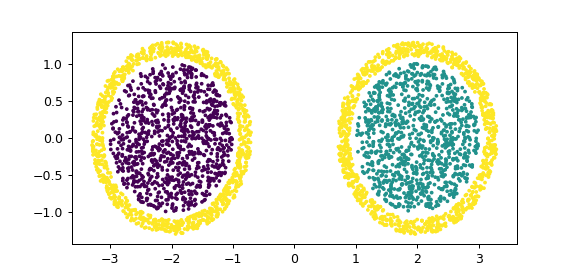

Plot of input data


In [31]:
# Plot input data

data = np.concatenate((classifier.data, classifier.data_out), axis=0)
labels = np.concatenate((classifier.labels, classifier.labels_out), axis=0)
fig=plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=4, c=labels.squeeze())
print("Plot of input data")

<IPython.core.display.Javascript object>


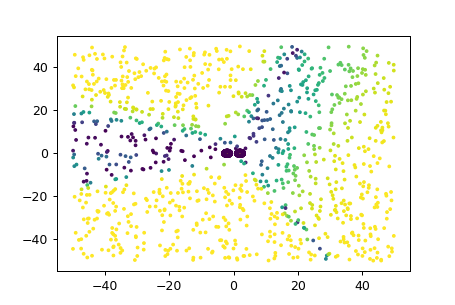

In [32]:
# Plot classified data - for test data

X_test = np.concatenate((classifier.X_test, classifier.X_test_outliers, classifier.data_outlier), axis=0)
y_test = np.concatenate((classifier.y_test, classifier.y_test_outliers, classifier.labels_outlier), axis=0)

#X_test = np.concatenate((classifier.X_test, classifier.data_outlier), axis=0)
#y_test = np.concatenate((classifier.y_test, classifier.labels_outlier), axis=0)


#X_test = np.concatenate((classifier.X_test, classifier.X_test_outliers), axis=0)
#y_test = np.concatenate((classifier.y_test, classifier.y_test_outliers), axis=0)

y_pred = classifier.model.predict(X_test)
y_max = y_pred.max(axis = -1)

# Plot classified data - for test data

#y_labels = y_pred.argmax(axis = -1)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(X_test[:, 0], X_test[:, 1], y_max, c=y_test.squeeze())
plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())


In [33]:
print(y_max.shape)
print(np.where(y_max>0.95)[0].shape)
print(np.where(y_max<0.55)[0].shape)

(3000,)
(1616,)
(1055,)


In [34]:
print(classifier.data_outlier.shape)

(1000, 2)


In [35]:
print(X_test.shape)
print(y_max.shape)
print(y_test.shape)

(3000, 2)
(3000,)
(3000, 1)
